<a href="https://colab.research.google.com/github/luigimersico/Topic_modelling/blob/main/bibliometric_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas matplotlib seaborn pybliometrics scikit-learn numpy networkx python-louvain igraph cairocffi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.2/74.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 8.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import igraph as ig
import cairocffi as cairo
from collections import Counter
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from gensim.models import CoherenceModel
from sklearn.preprocessing import normalize
from networkx.algorithms import community
from sklearn.decomposition import NMF

#from pybliometrics.scopus import ScopusSearch # if you want to import files from scopus be sure to have a valid API provided by elsevier

In [75]:
# Load the Excel file exported from R bibliometrix library
excel_file = "/content/drive/MyDrive/Colab_Notebooks/input_data/reviews_plastics_policies/eligible_article_dataset.xlsx"
df = pd.read_excel(excel_file)

In [4]:
# Basic statistics
total_journals = df['SO'].nunique() # Extract unique journal names from the 'SO' column and count them
total_papers = len(df)
total_citations = df['TC'].sum()  # Assuming 'CR' contains cited references
average_citations_per_paper = total_citations / total_papers
all_authors = df['AU'].str.split(';').explode().dropna()
total_authors = len(all_authors.unique())

print("Total Number of Journals:", total_journals)
print("Total papers:", total_papers)
print("Total citations:", total_citations)
print("Average citations per paper:", average_citations_per_paper)
print("Total number of authors:", total_authors)

Total Number of Journals: 39
Total papers: 62
Total citations: 1627
Average citations per paper: 26.241935483870968
Total number of authors: 183


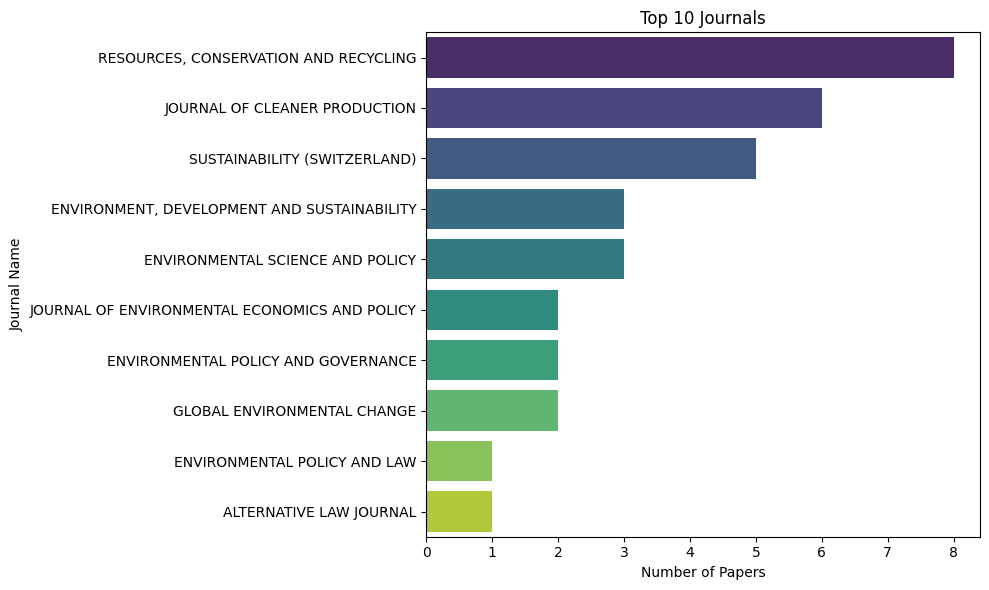

Top 10 Journals:
RESOURCES, CONSERVATION AND RECYCLING            8
JOURNAL OF CLEANER PRODUCTION                    6
SUSTAINABILITY (SWITZERLAND)                     5
ENVIRONMENT, DEVELOPMENT AND SUSTAINABILITY      3
ENVIRONMENTAL SCIENCE AND POLICY                 3
JOURNAL OF ENVIRONMENTAL ECONOMICS AND POLICY    2
ENVIRONMENTAL POLICY AND GOVERNANCE              2
GLOBAL ENVIRONMENTAL CHANGE                      2
ENVIRONMENTAL POLICY AND LAW                     1
ALTERNATIVE LAW JOURNAL                          1
Name: SO, dtype: int64


In [5]:
# TOP JOURNALS
# Count the occurrences of each journal and get the top 5
top_journals = df['SO'].value_counts().head(10)

# Plotting the top 5 journals with a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_journals.values, y=top_journals.index, palette='viridis')
plt.title("Top 10 Journals")
plt.xlabel("Number of Papers")
plt.ylabel("Journal Name")
plt.tight_layout()
plt.show()

# Display the top 5 journals
print("Top 10 Journals:")
print(top_journals)

+----+-----------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------+------+---------------------------------------------+------+
|    | AU                                                                                                  | TI                                                                                                                |   PY | SO                                          |   TC |
+====+=====================================================================================================+===================================================================================================================+======+=============================================+======+
| 39 | CONVERY F;MCDONNELL S;FERREIRA S                                                                    | THE MOST POPULAR TAX IN EUROPE? LESS

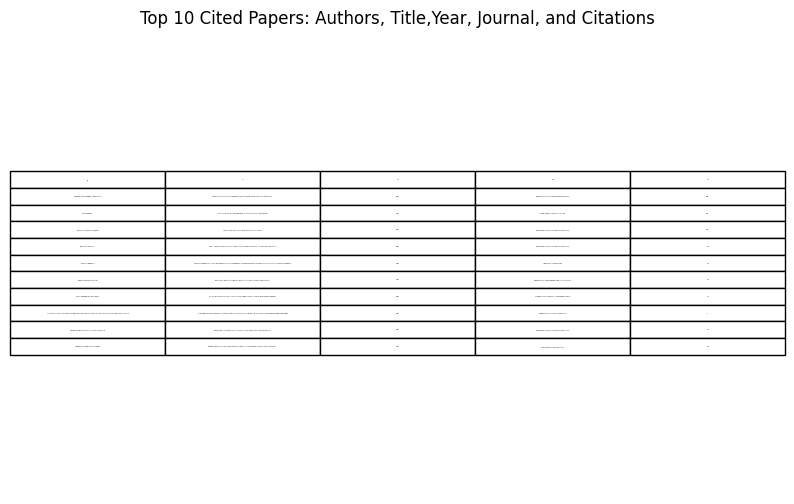

In [8]:
# TOP CITED PAPERS
# Extract and clean the 'TC' (Total Citations) column
df['TC'] = pd.to_numeric(df['TC'], errors='coerce').fillna(0)  # Convert TC to numeric, replace NaN with 0

# Sort the DataFrame based on total citations to get the top 10 cited papers
top_cited_papers = df.sort_values(by='TC', ascending=False).head(10)

# Create a data table with authors, journal, and citations
data_table = top_cited_papers[['AU', 'TI','PY', 'SO', 'TC']]

# Print the data table using tabulate library
table_str = tabulate(data_table, headers='keys', tablefmt='grid')

# Display the table
print(table_str)

# Plotting the data table
plt.figure(figsize=(10, 6))
plt.axis('off')  # Turn off axis
plt.table(cellText=data_table.values, colLabels=data_table.columns, cellLoc='center', loc='center')
plt.title("Top 10 Cited Papers: Authors, Title,Year, Journal, and Citations")
plt.show()

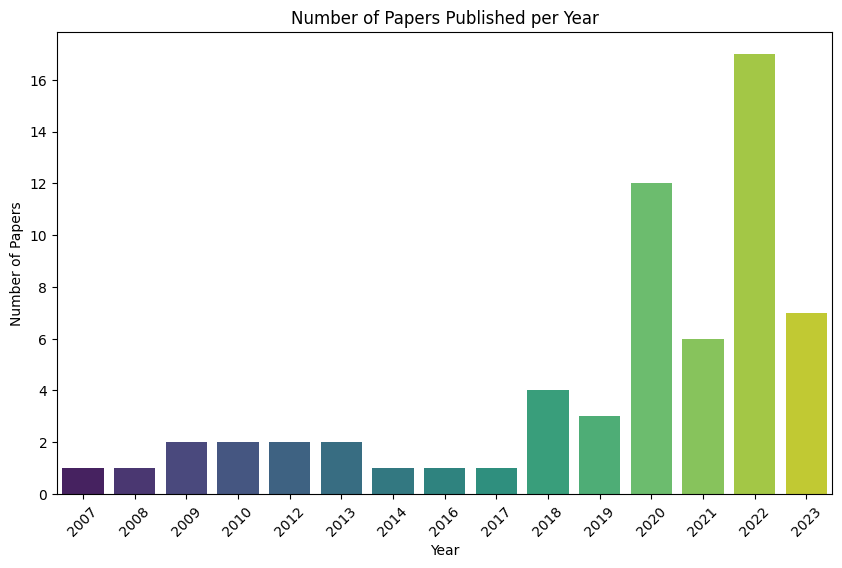

Papers published per year:
2007     1
2008     1
2009     2
2010     2
2012     2
2013     2
2014     1
2016     1
2017     1
2018     4
2019     3
2020    12
2021     6
2022    17
2023     7
Name: Year, dtype: int64


In [9]:
# Convert the 'PY' column to string and then extract publication year
df['Year'] = df['PY'].astype(str).str.extract(r'(\d{4})')

# Calculate the number of papers published per year
papers_per_year = df['Year'].value_counts().sort_index()
# Plotting the number of papers per year
plt.figure(figsize=(10, 6))
sns.barplot(x=papers_per_year.index, y=papers_per_year.values, palette='viridis')
plt.title("Number of Papers Published per Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.xticks(rotation=45)
plt.show()
# Display the number of papers published per year
print("Papers published per year:")
print(papers_per_year)

In [11]:
# Calculate the top authors
top_authors = df['AU'].str.split(';').explode().value_counts().head(10)

In [12]:
top_authors

DIKGANG J        3
KAMARUDDIN H     2
WANG Y           2
PAZIENZA P       2
DE LUCIA C       2
MASKUN M         2
VAN PASSEL S     2
COMPERNOLLE T    2
DE JAEGER S      2
DE WEERDT L      2
Name: AU, dtype: int64

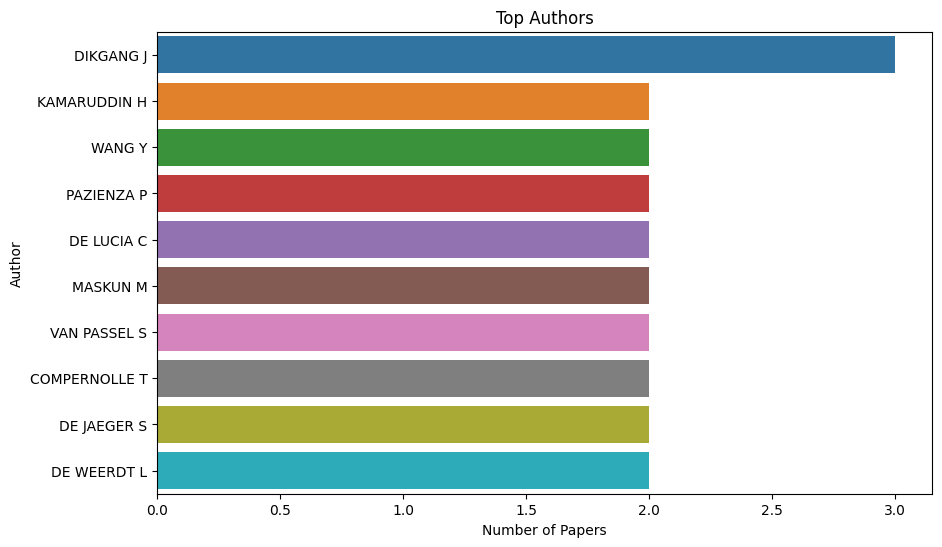

In [13]:
# Visualize the author frequency
plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index)
plt.title("Top Authors")
plt.xlabel("Number of Papers")
plt.ylabel("Author")
plt.show()

In [14]:
import geopandas as gpd
from geopandas.tools import geocode
from shapely.geometry import Point

In [15]:
# Extract and clean author affiliations
addresses = df['C1'].str.split(', ').explode().str.strip()

In [16]:
addresses.head()

0         PORTUGAL
1        AUSTRALIA
2    UNITED STATES
3           CANADA
4     SOUTH AFRICA
Name: C1, dtype: object

In [17]:
# Geocode the addresses to get geographical coordinates
geocoded_addresses = geocode(addresses, provider='nominatim', user_agent='my_geocoder')


In [18]:
# Create a GeoDataFrame with the coordinates
gdf = gpd.GeoDataFrame(geocoded_addresses, geometry=geocoded_addresses.geometry)

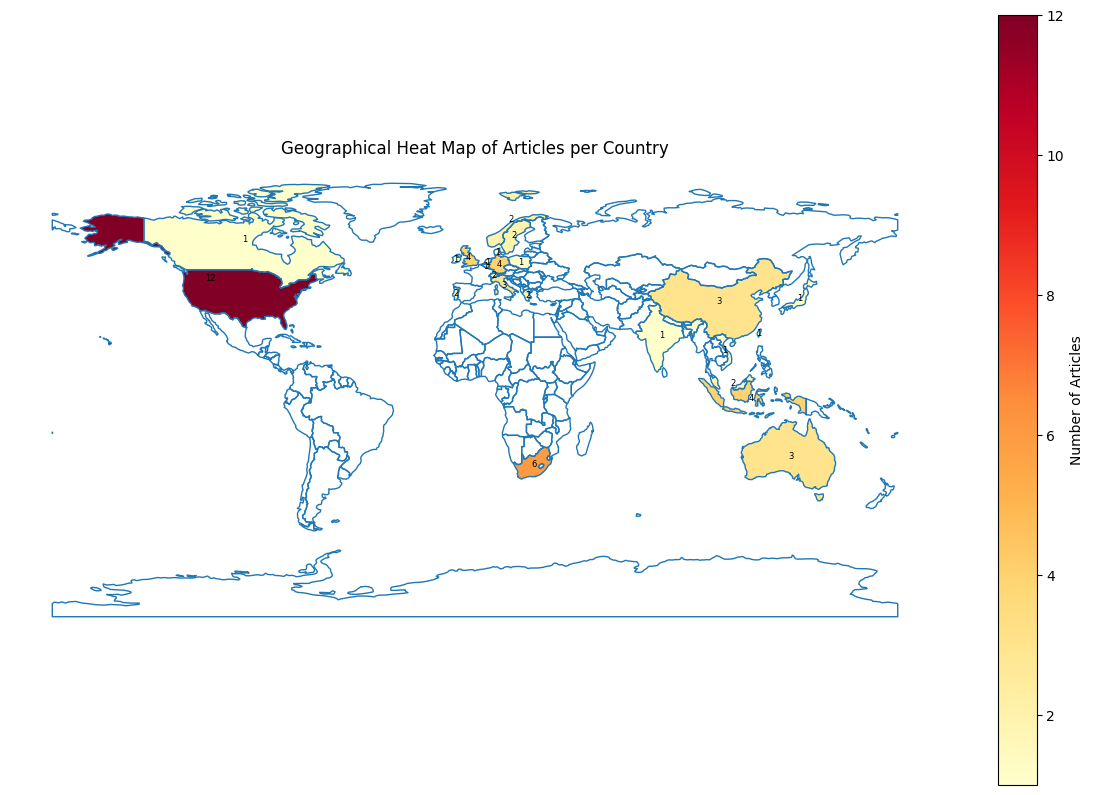

In [90]:
# Heat map of publications by countries in which first author is based

# Group the dataset by "C1" column and count the number of articles per country
country_counts = df.groupby('C1').size().reset_index(name='Article Count')

# Load the world map shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Preprocess country names in the world map and dataset
world['name'] = world['name'].str.upper()  # Convert to uppercase for consistency
df['C1'] = df['C1'].str.upper()  # Convert to uppercase for consistency

# Merge the world map with the country counts
merged = world.merge(country_counts,
                     left_on="name", right_on="C1", how="left")

# Fill NaN values in the merged dataset with 0
merged['Article Count'] = merged['Article Count'].fillna(0)

# Plot the geographical heat map with annotations
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_axis_off()  # Turn off both x and y axes
merged.boundary.plot(ax=ax, linewidth=1)
plot = merged[merged['Article Count'] > 0].plot(column='Article Count', ax=ax, legend=True,
                                                 legend_kwds={'label': "Number of Articles"},
                                                 cmap='YlOrRd', missing_kwds={"color": "lightgrey"})

# Annotate the number of articles per country
for idx, row in merged.iterrows():
    if row['Article Count'] > 0:
        plot.annotate(text=str(int(row['Article Count'])),
                      xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                      horizontalalignment='center', verticalalignment='center',
                      fontsize=6, color='black')

plt.title("Geographical Heat Map of Articles per Country")
plt.show()

END EDA


START SCIENCE MAPPING to analyze the relationships and patterns within the corpus analyzing abstracts to provide insights into the topics and trends present in the research.

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

## Hypotesis 1 NMF topic modelling

In [ ]:
## Hypotesis 1 NMF topic modelling

# Extract and clean the 'AB' (Abstract) column
abstracts = df['AB'].fillna('').str.lower().str.replace('[^\w\s]', '')

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
X = vectorizer.fit_transform(abstracts)

# Perform NMF topic modeling
num_topics = 5  # Change this as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_W = nmf_model.fit_transform(X)
nmf_H = nmf_model.components_

# Get the top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words_per_topic = []
for topic_idx, topic_weights in enumerate(nmf_H):
    top_words_idx = topic_weights.argsort()[:-10-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_words_per_topic.append(top_words)

# Display the top words for each topic
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


Topic 1: plastics, global, pollution, policies, international, governance, marine, policy, reduce, framework
Topic 2: bags, bag, use, disposable, charge, consumers, levy, free, ban, study
Topic 3: waste, recycling, incineration, management, industrial, policy, european, disposal, current, resources
Topic 4: tax, environmental, bottled, taxes, water, damage, packaging, demand, effect, eu
Topic 5: legal, indonesia, approaches, malaysia, waste, deal, issues, various, issue, instruments


<ipython-input-18-71ca8eee6dd6>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  abstracts = df['AB'].fillna('').str.lower().str.replace('[^\w\s]', '')


### Hypotesis 2


In [ ]:
# Handle missing values by replacing them with empty strings
df['DE'] = df['DE'].fillna('')

# Create a term co-occurrence matrix
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['DE'])
co_occurrence_matrix = (X.T @ X).toarray()

# Create an igraph graph object
G = ig.Graph.Adjacency(co_occurrence_matrix.tolist(), mode="UNDIRECTED")

# Assign vertex attributes
G.vs["term"] = vectorizer.get_feature_names_out()
G.vs["degree_value"] = G.degree()

# Detect communities using Louvain algorithm (no edge weights)
communities = G.community_multilevel()

# Set up igraph plot
layout = G.layout_fruchterman_reingold()
visual_style = {
    "layout": layout,
    "vertex_size": [min(1, size * 20) for size in G.vs["degree_value"]],
    "bbox": (800, 800),
    "margin": 50,
    "vertex_label": G.vs["term"],
}

# Plot the graph with communities
ig.plot(communities, **visual_style)

plt.show()